Ticker selections
=================

In [16]:
# If you would like to refresh your data, please execute the bellow codes.

import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

from mypo import Loader

DOWNLOAD = False

if DOWNLOAD:
    tickers = pd.read_csv("/app/docs/tutorial/tickers.csv")
    loader = Loader()
    for row in tqdm(tickers.to_dict('record')):
        loader.get(row['Ticker'], expense_ratio=row['ExpenseRatio'] * 0.01)
    loader.save('/app/docs/tutorial/all.bin')

In [17]:
loader = Loader.load('/app/docs/tutorial/all.bin')
loader = loader.since(datetime(2005, 1, 1))

market = loader.get_market()

In [18]:
pd.set_option('display.max_rows', 200)

summary = loader.summary()
summary = summary.sort_index()
summary

,established,names,total_assets,volume,expense_ratio
AGG,2003-09-29,iShares Core U.S. Aggregate Bond ETF,85938724864,6466483,0.0005
BBH,1999-11-23,VanEck Vectors Biotech ETF,495472128,6928,0.0035
DIA,1998-01-20,SPDR Dow Jones Industrial Average ETF Trust,25793642496,4995800,0.0016
DVY,2003-11-07,iShares Select Dividend ETF,15882481664,1065285,0.0039
EEM,2003-04-14,iShares MSCI Emerging Markets ETF,29338421248,65868433,0.0070
EFA,2001-08-27,iShares MSCI EAFE ETF,53298008064,24144216,0.0032
EPP,2001-10-26,iShares MSCI Pacific ex Japan ETF,2290522112,271300,0.0048
EWG,1996-03-18,iShares MSCI Germany ETF,2596413952,3059500,0.0051
EWJ,1996-03-18,iShares MSCI Japan ETF,13236024320,6636166,0.0051
EWM,1996-03-18,iShares MSCI Malaysia ETF,380267392,300166,0.0051


In [19]:
print(market.get_summary().sort_index())
tickers = market.get_tickers()
tickers.remove('SHY')
tickers.remove('AGG')

market = market.filter(tickers)

      daily return      variance  sharp ratio
AGG       0.000158  9.637003e-06    16.443447
BBH       0.000651  2.007510e-04     3.243386
DIA       0.000442  1.426655e-04     3.100646
DVY       0.000377  1.596410e-04     2.361359
EEM       0.000476  3.514801e-04     1.355455
EFA       0.000309  1.965768e-04     1.570381
EPP       0.000425  2.613880e-04     1.626070
EWG       0.000383  2.686108e-04     1.427280
EWJ       0.000265  1.744516e-04     1.518079
EWM       0.000283  1.752569e-04     1.615122
EWS       0.000393  2.354161e-04     1.671178
EWT       0.000464  2.620832e-04     1.768740
EWW       0.000397  3.290586e-04     1.206546
EWY       0.000534  3.970241e-04     1.344488
EWZ       0.000546  6.170905e-04     0.884256
EZA       0.000482  5.085734e-04     0.948013
FEZ       0.000316  2.870620e-04     1.100081
FVD       0.000459  1.222106e-04     3.756687
FXI       0.000534  4.385859e-04     1.217338
GLD       0.000380  1.316154e-04     2.889224
IBB       0.000570  2.267076e-04  

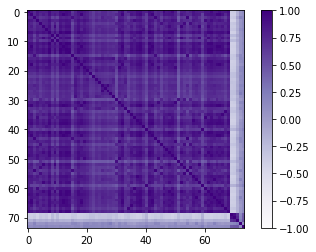

,FVD,IWM,IXC,IXG,IXJ,IXN,IXP,IVV,IYR,QQQ,...,VBK,VBR,VCR,VDC,DIA,TLT,IEF,TIP,GLD,LQD
FVD,1.000000,0.866347,0.749267,0.859915,0.801899,0.796766,0.801134,0.915445,0.788080,0.789095,...,0.850322,0.902098,0.849670,0.845053,0.901211,-0.377956,-0.362550,-0.160604,0.040931,0.145087
IWM,0.866347,1.000000,0.748146,0.851466,0.757650,0.825406,0.770002,0.910345,0.783193,0.838424,...,0.968264,0.973623,0.894494,0.741009,0.872141,-0.398788,-0.393568,-0.166706,0.039747,0.104112
IXC,0.749267,0.748146,1.000000,0.755630,0.658896,0.693423,0.723924,0.796592,0.584143,0.663526,...,0.749881,0.770843,0.688173,0.621855,0.790183,-0.369691,-0.346013,-0.068387,0.184039,0.148874
IXG,0.859915,0.851466,0.755630,1.000000,0.748462,0.792638,0.799920,0.892898,0.776972,0.763760,...,0.830567,0.887881,0.831116,0.705058,0.865690,-0.431998,-0.421938,-0.167888,0.034980,0.125309
IXJ,0.801899,0.757650,0.658896,0.748462,1.000000,0.767705,0.785283,0.858532,0.631770,0.789068,...,0.781919,0.750373,0.761782,0.781427,0.841680,-0.346288,-0.324097,-0.138472,0.053027,0.150541
IXN,0.796766,0.825406,0.693423,0.792638,0.767705,1.000000,0.813468,0.910342,0.672716,0.951295,...,0.869056,0.806657,0.860371,0.733284,0.871600,-0.364510,-0.362002,-0.160413,0.054102,0.138347
IXP,0.801134,0.770002,0.723924,0.799920,0.785283,0.813468,1.000000,0.867437,0.676028,0.812064,...,0.789873,0.774531,0.801592,0.755577,0.847570,-0.331397,-0.323910,-0.127737,0.107095,0.174232
IVV,0.915445,0.910345,0.796592,0.892898,0.858532,0.910342,0.867437,1.000000,0.782932,0.919098,...,0.920425,0.915322,0.922325,0.848233,0.971586,-0.419069,-0.412891,-0.183822,0.039927,0.132572
IYR,0.788080,0.783193,0.584143,0.776972,0.631770,0.672716,0.676028,0.782932,1.000000,0.676491,...,0.762739,0.830373,0.768119,0.672800,0.745535,-0.241348,-0.240959,-0.101207,0.048909,0.135970
QQQ,0.789095,0.838424,0.663526,0.763760,0.789068,0.951295,0.812064,0.919098,0.676491,1.000000,...,0.885500,0.806597,0.888575,0.750314,0.866875,-0.366244,-0.367082,-0.178444,0.025197,0.118011


In [20]:
import matplotlib.pyplot as plt
from mypo import clustering_tickers, evaluate_combinations

CLUSTERS = 3
cluster = clustering_tickers(market, n=CLUSTERS)
corr = market.get_rate_of_change()[cluster.index].corr()

plt.figure()
plt.imshow(corr,interpolation='nearest',vmin=-1,vmax=1,cmap='Purples')
plt.colorbar()
plt.show()

corr

In [21]:
from mypo import split_k_folds
from mypo.optimizer import MinimumVarianceOptimizer, MaximumDiversificationOptimizer
from mypo.indicator import yearly_total_return, max_drawdown, max_drawdown_span
from mypo.rebalancer import MonthlyRebalancer
from mypo import Runner

folds = split_k_folds(market, 4, 200)

  1%|          | 7/979 [00:00<00:14, 66.19it/s]

['EWZ', 'IEF', 'GLD']


100%|██████████| 979/979 [00:11<00:00, 88.69it/s]


[0.11327665 0.83850826 0.04821509]
1.1414351774619622
0.8996235571035714
145


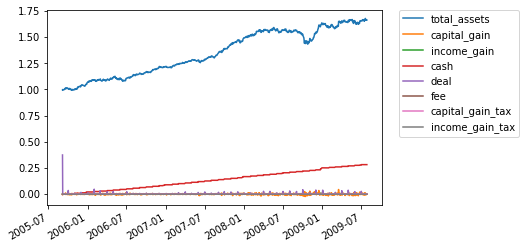

  1%|          | 5/979 [00:00<00:21, 46.07it/s]

['RWR', 'IEF', 'GLD']


100%|██████████| 979/979 [00:10<00:00, 89.32it/s]


[0.23717573 0.63921836 0.12360591]
1.1204268841834044
0.9390310426182747
115


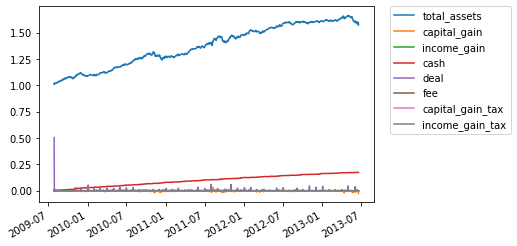

  1%|          | 8/979 [00:00<00:15, 61.67it/s]

['FEZ', 'IEF', 'GLD']


100%|██████████| 979/979 [00:10<00:00, 89.85it/s]


[0.21760864 0.6723192  0.11007216]
1.054314276193345
0.9381450078282896
229


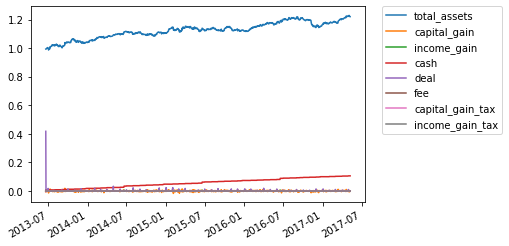

  1%|          | 8/979 [00:00<00:12, 76.99it/s]

['XLF', 'IEF', 'GLD']


100%|██████████| 979/979 [00:11<00:00, 88.14it/s]


[0.13179153 0.82466499 0.04354348]
1.065098820140876
0.9082820600757007
233


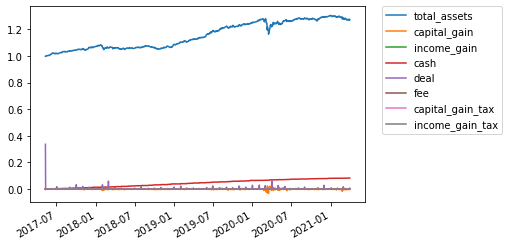

In [22]:
for i in range(len(folds)):
    evaluates = evaluate_combinations(folds[i].get_train(), cluster, optimizer=MaximumDiversificationOptimizer(), verbose=True)
    print(list(evaluates['combinations'])[0])
    fold = folds[i].filter((list(evaluates['combinations'])[0]))
    optimizer = MaximumDiversificationOptimizer()
    runner = Runner(
        assets=np.ones(CLUSTERS)/CLUSTERS,
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
        cash=0
    )

    runner.run_fold(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(optimizer.get_weights())
    print(yearly_total_return(report))
    print(max_drawdown(report))
    print(max_drawdown_span(report))
    ax = report.plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

  1%|          | 8/979 [00:00<00:13, 73.18it/s]

['EWZ', 'TLT', 'LQD']


100%|██████████| 979/979 [00:11<00:00, 87.93it/s]


[0.17576079 0.6911375  0.13310172]
1.1141122713368732
0.8252374242457051
154


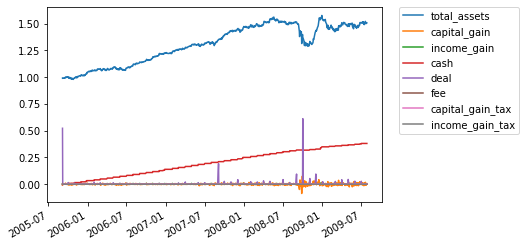

  1%|          | 5/979 [00:00<00:20, 47.32it/s]

['EWZ', 'TIP', 'LQD']


100%|██████████| 979/979 [00:10<00:00, 89.32it/s]


[0.16190826 0.49567037 0.34242137]
1.0891160814565906
0.9311519410767242
101


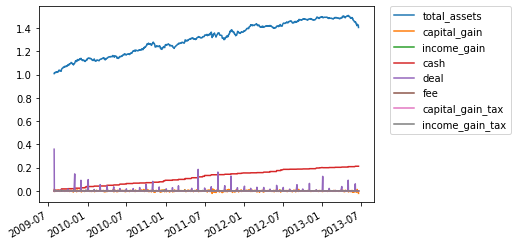

  1%|          | 8/979 [00:00<00:15, 64.08it/s]

['BBH', 'IEF', 'LQD']


100%|██████████| 979/979 [00:10<00:00, 89.62it/s]


[1.98533639e-01 8.01466361e-01 8.02309608e-18]
1.069683060176965
0.9373182460079355
244


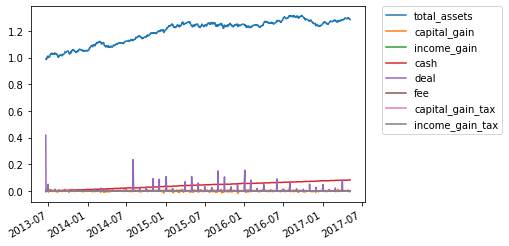

  1%|          | 8/979 [00:00<00:12, 79.55it/s]

['IXN', 'TIP', 'LQD']


100%|██████████| 979/979 [00:10<00:00, 90.11it/s]


[0.18348974 0.81651026 0.        ]
1.1030380279850274
0.8822074283563757
131


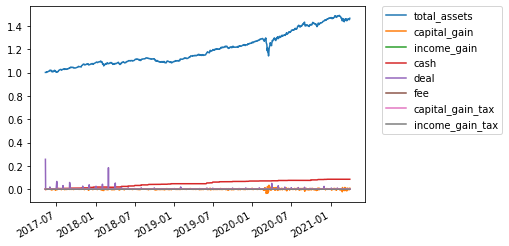

In [23]:
for i in range(len(folds)):
    df = pd.concat([folds[i].get_train().get_summary(), cluster], axis=1)
    selected_tickers = list(df.groupby('class').idxmax().reset_index(drop=True)['daily return'])
    print(selected_tickers)
    fold = folds[i].filter(selected_tickers)
    optimizer = MaximumDiversificationOptimizer()
    runner = Runner(
        assets=np.ones(CLUSTERS)/CLUSTERS,
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
        cash=0
    )

    runner.run_fold(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(optimizer.get_weights())
    print(yearly_total_return(report))
    print(max_drawdown(report))
    print(max_drawdown_span(report))
    ax = report.plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

  1%|          | 8/979 [00:00<00:12, 79.22it/s]

['VPU', 'TIP', 'LQD']


100%|██████████| 979/979 [00:10<00:00, 90.58it/s]


[0.20669305 0.66185944 0.13144751]
1.093935132514222
0.8606623956915547
265


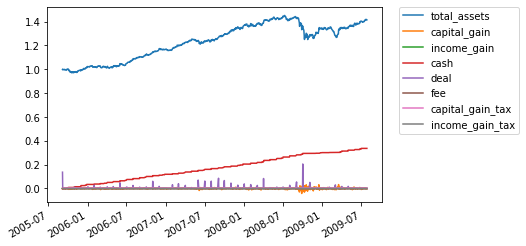

  1%|          | 6/979 [00:00<00:16, 58.87it/s]

['BBH', 'TIP', 'LQD']


100%|██████████| 979/979 [00:10<00:00, 90.82it/s]


[0.16655792 0.4519932  0.38144889]
1.1330735234108735
0.9493263877698019
87


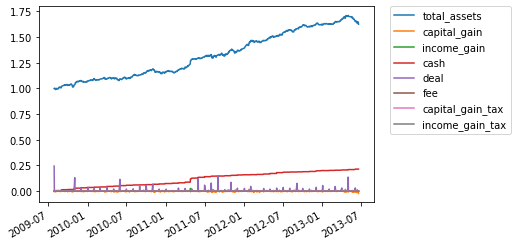

  1%|          | 8/979 [00:00<00:14, 64.99it/s]

['PPH', 'TLT', 'GLD']


100%|██████████| 979/979 [00:10<00:00, 91.57it/s]


[0.40314279 0.35831797 0.23853924]
1.0828427609780875
0.8578876690067744
302


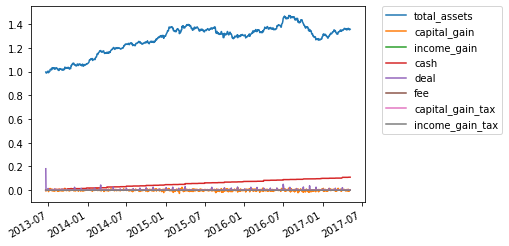

  1%|          | 9/979 [00:00<00:11, 82.57it/s]

['DIA', 'TIP', 'LQD']


100%|██████████| 979/979 [00:10<00:00, 90.75it/s]


[1.96230981e-01 8.03769019e-01 3.27971157e-18]
1.091589607423905
0.865929411251807
139


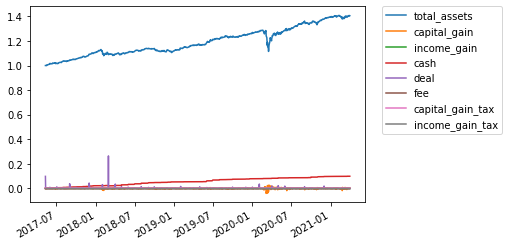

In [24]:
for i in range(len(folds)):
    df = pd.concat([folds[i].get_train().get_summary(), cluster], axis=1)
    selected_tickers = list(df.groupby('class').idxmax().reset_index(drop=True)['sharp ratio'])
    print(selected_tickers)
    fold = folds[i].filter(selected_tickers)
    optimizer = MaximumDiversificationOptimizer()
    runner = Runner(
        assets=np.ones(CLUSTERS)/CLUSTERS,
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
        cash=0
    )

    runner.run_fold(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(optimizer.get_weights())
    print(yearly_total_return(report))
    print(max_drawdown(report))
    print(max_drawdown_span(report))
    ax = report.plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()